
# Time Syncronization of DESI Telemetry Data

As is, the DESI telemetry data is spread out across multiple different tables. As is is shown in the correlations plots in the `correlation` folder, there us very weak correlation across different tables. Before proper analysis can be done, the several datatables of interest must 
be syncronized in time. This involves rebinning and interpolation of the data is currently being hosted by NERSC.

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

## Load Data

In [3]:
tower_data = pd.read_pickle('../environmentmonitor_tower.pkl')
dome_data = pd.read_pickle('../environmentmonitor_dome.pkl')
telescope_data = pd.read_pickle('../environmentmonitor_telescope.pkl')
etc_seeing_data = pd.read_pickle('../etc_seeing.pkl')
etc_telemetry_data = pd.read_pickle('../etc_telemetry.pkl')
tcs_info_data = pd.read_pickle('../tcs_info.pkl')

## TODO: Sort Data

## Data Visualization Before Syncrization

In [15]:
start_date = pd.Timestamp(year=2019,month=10,day=15,hour=0,minute=0,second=0,microsecond=0)
end_date = pd.Timestamp(year=2023,month=1,day=1,hour=0,minute=0,second=0,microsecond=0)
print(start_date)
print(end_date)
print(end_date-start_date)
assert(start_date<end_date)

2019-10-15 00:00:00
2023-01-01 00:00:00
1174 days 00:00:00


In [35]:
# Do the start dates of the tables match?
print(tower_data['time_recorded'][0])
print(dome_data['time_recorded'][0])
print(telescope_data['time_recorded'][0])

2020-08-13 18:47:10.476695+00:00
2019-09-18 21:56:19.520599+00:00
2022-06-10 16:37:05.419966+00:00


The start dates of different environment data tables is not consistant, 

In [30]:
print(type(start_date+pd.DateOffset(days=1)))
print(start_date+pd.DateOffset(days=1))

2019-12-16 00:00:00-07:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [16]:
print(len(telescope_data))
print(telescope_data['time_recorded'][len(telescope_data)-1])

18592072
2022-06-10 16:36:59.593400+00:00


In [10]:
def new_temperature_plot(year=2021, month=12, day=15, offset=1):
    start_date = pd.Timestamp(year=year,month=month,day=day,hour=12,minute=0,second=0,microsecond=0, tz="America/Phoenix")
    end_date = start_date+pd.DateOffset(days=offset)
    
    print(f'Start date: {start_date}')
    print(f'Offset length (# of days): {offset}')
    
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    ax0_plots = []
    ax1_plots = []
    
    telescope_time = telescope_data['time_recorded'].to_numpy()
    telescope_indicies = np.argwhere(np.logical_and(telescope_time >= start_date, telescope_time <= end_date)).flatten()
    print(f'Number of valid telescope environment samples in current time window: {len(telescope_indicies)}')
    if len(telescope_indicies):
        ax0_plots.append(ax[0].plot(telescope_time[telescope_indicies], telescope_data['mirror_temp'][telescope_indicies], label='mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_time[telescope_indicies], telescope_data['mirror_avg_temp'][telescope_indicies], label='average mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_time[telescope_indicies], telescope_data['mirror_desired_temp'][telescope_indicies], label='desired mirror temp')[0])
        ax0_plots.append(ax[0].plot(telescope_time[telescope_indicies], telescope_data['air_temp'][telescope_indicies], label='air temp')[0])
    
    etc_telemetry_time = etc_telemetry_data['time_recorded'].to_numpy()
    etc_telemetry_indicies = np.argwhere(np.logical_and(etc_telemetry_time >= start_date, etc_telemetry_time <= end_date)).flatten()
    print(f'Number of valid etc telemetry samples in current time window: {len(etc_telemetry_indicies)}')
    if len(etc_telemetry_indicies):
        twin0 = ax[0].twinx()
        ax0_plots.append(twin0.plot(*zip(*sorted(zip(*(etc_telemetry_time[etc_telemetry_indicies],etc_telemetry_data['seeing'][etc_telemetry_indicies])))), color="indigo", label='seeing')[0])
        twin0.autoscale(True)
        twin0.set_ylabel('Seeing')
    
    dome_time = dome_data['time_recorded'].to_numpy()
    dome_indicies = np.argwhere(np.logical_and(dome_time >= start_date, dome_time <= end_date)).flatten()
    print(f'Number of valid dome environment samples in current time window: {len(dome_indicies)}')
    if len(dome_indicies):
        ax1_plots.append(ax[1].plot(dome_time[dome_indicies], dome_data['dome_floor_ne'][dome_indicies], label='dome floor temp (NE)')[0])
        ax1_plots.append(ax[1].plot(dome_time[dome_indicies], dome_data['dome_floor_nw'][dome_indicies], label='dome floor temp (NW)')[0])
        ax1_plots.append(ax[1].plot(dome_time[dome_indicies], dome_data['dome_floor_s'][dome_indicies], label='dome floor temp (S)')[0])

    tower_time = tower_data['time_recorded'].to_numpy()
    tower_indicies = np.argwhere(np.logical_and(tower_time >= start_date, tower_time <= end_date)).flatten()
    print(f'Number of valid tower environment samples in current time window: {len(tower_indicies)}')
    if len(tower_indicies):
        twin1 = ax[1].twinx()
        ax1_plots.append(twin1.plot(tower_time[tower_indicies], tower_data['temperature'][tower_indicies], color="indigo", label='tower temp')[0])
        twin1.autoscale(True)
        twin1.set_ylabel('Tower Temperature (Celcius)')
                  
    if ax0_plots and ax1_plots:
        ax[0].legend(handles=ax0_plots)
        ax[0].autoscale(True)
        ax[0].set_title('Mirror Temperature & Seeing vs. Date/Time')
        ax[0].set_ylabel('Mirror Temperature (Celcius)')
        ax[0].set_xlabel('Date/Time')

        ax[1].legend(handles=ax1_plots)
        ax[1].autoscale(True)
        ax[1].set_title('Dome & Tower Temperature vs. Date/Time')
        ax[1].set_ylabel('Dome Temperature (Celcius)')
        ax[1].set_xlabel('Date/Time')
        
        # plt.savefig(f'time_plots/{year}-{month}-{day}_{offset}-day-offset.png')
        plt.show()
    else:
        print("Insufficient data in this time window!")

Start date: 2022-06-10 12:00:00-07:00
Offset length (# of days): 1
Number of valid telescope environment samples in current time window: 14865
Number of valid etc telemetry samples in current time window: 5169
Number of valid dome environment samples in current time window: 14865
Number of valid tower environment samples in current time window: 14865


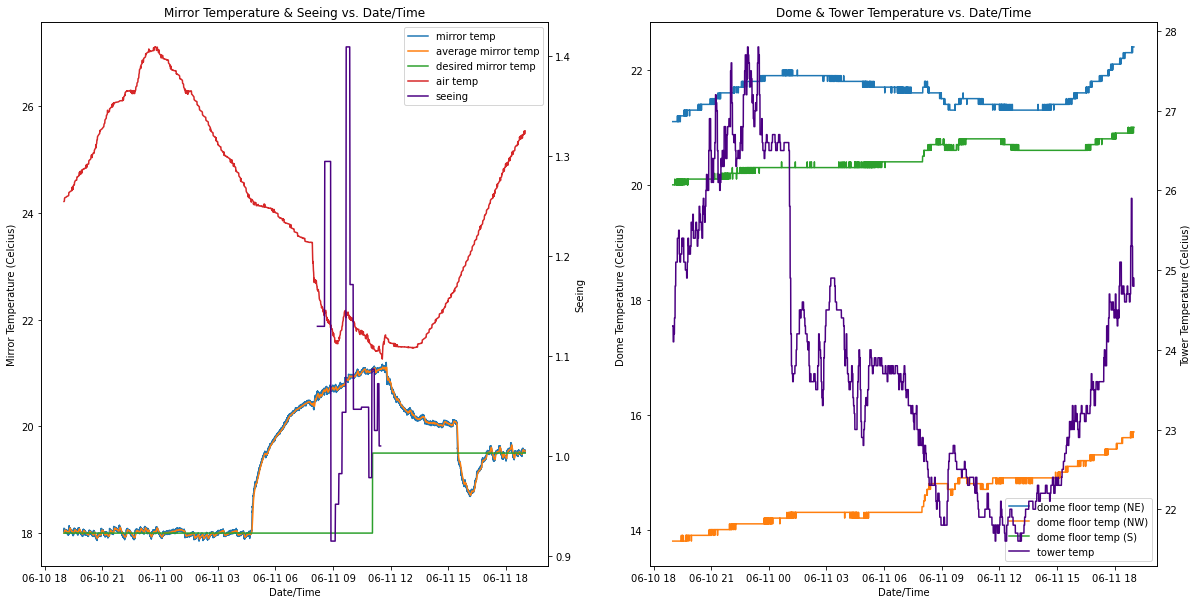

In [11]:
new_temperature_plot(year=2022, month=6, day=10, offset=1)

Start date: 2022-06-10 12:00:00-07:00
Offset length (# of days): 3
Number of valid telescope samples in current time window: 44556
Number of valid tower samples in current time window: 44556
Number of valid dome samples in current time window: 44556
Number of valid etc telemetry samples in current time window: 27829


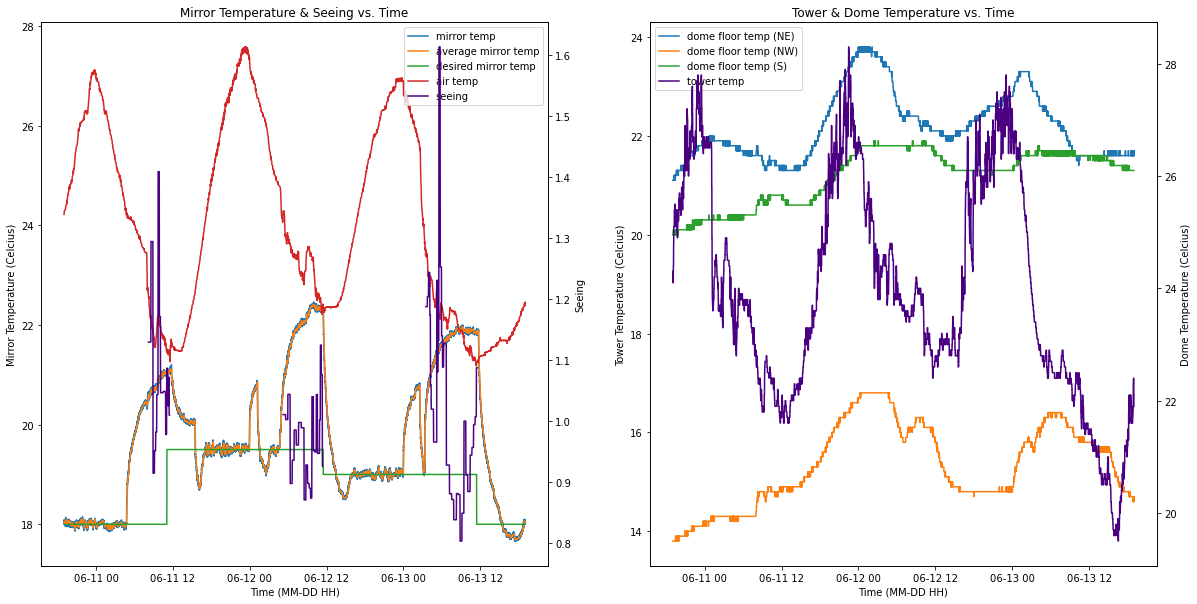

In [5]:
new_temperature_plot(year=2022, month=6, day=10, offset=3)

Start date: 2022-01-01 12:00:00-07:00
Offset length (# of days): 7
Number of valid telescope samples in current time window: 103433
Number of valid tower samples in current time window: 103433
Number of valid dome samples in current time window: 103434
Number of valid etc telemetry samples in current time window: 115843


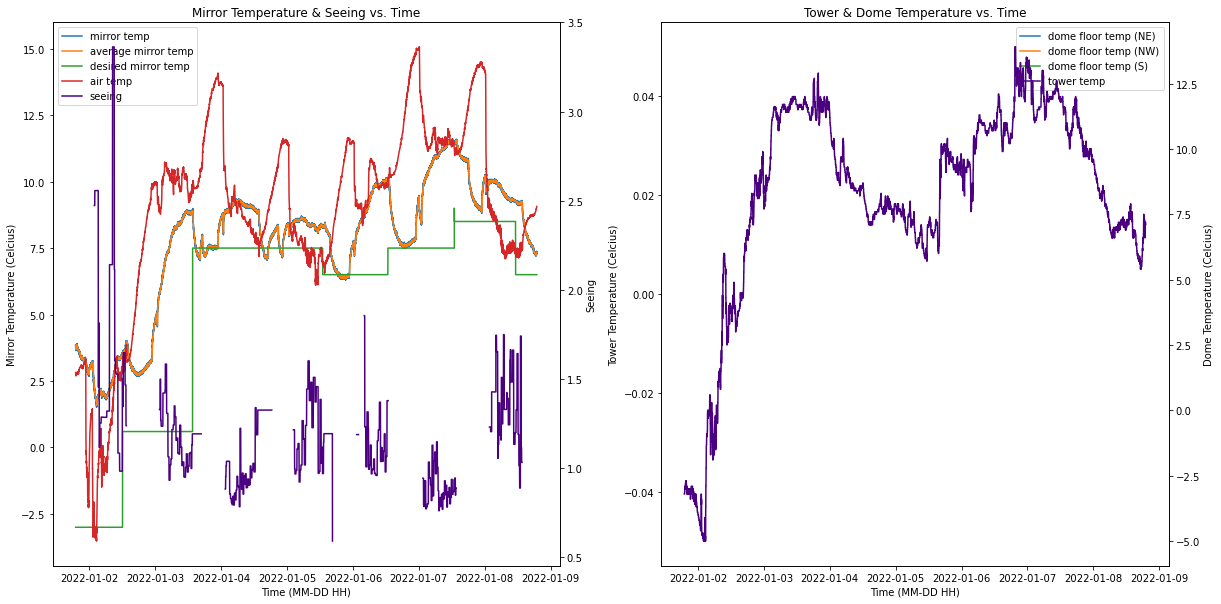

In [6]:
new_temperature_plot(year=2022, month=1, day=1, offset=7)

Start date: 2021-12-27 12:00:00-07:00
Offset length (# of days): 7
Number of valid telescope samples in current time window: 103399
Number of valid tower samples in current time window: 103399
Number of valid dome samples in current time window: 103399
Number of valid etc telemetry samples in current time window: 34675


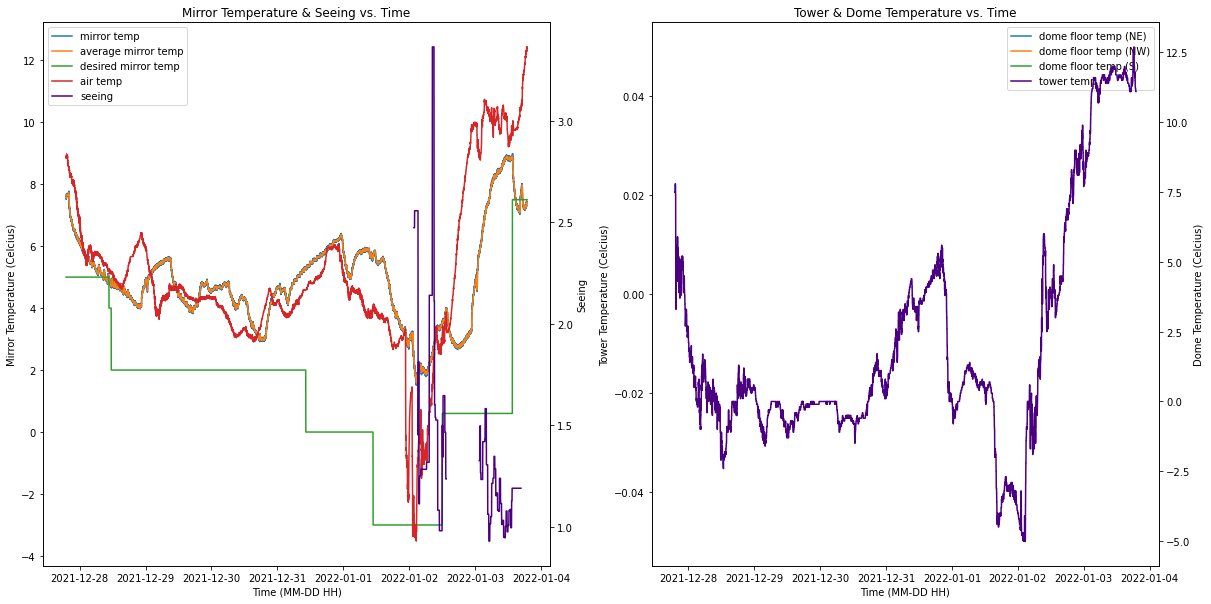

In [9]:
new_temperature_plot(year=2021, month=12, day=27, offset=7)

Start date: 2022-01-21 12:00:00-07:00
Offset length (# of days): 7
Number of valid telescope samples in current time window: 103871
Number of valid tower samples in current time window: 103871
Number of valid dome samples in current time window: 103871
Number of valid etc telemetry samples in current time window: 110109


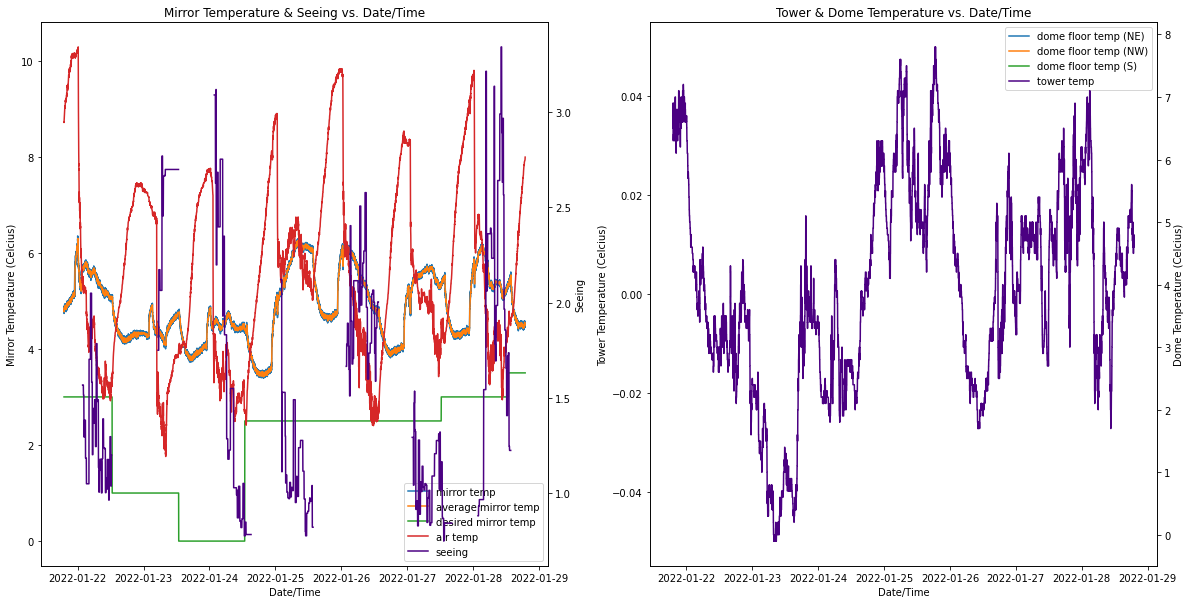

In [11]:
new_temperature_plot(year=2022, month=1, day=21, offset=7)

Start date: 2021-02-01 12:00:00-07:00
Offset length (# of days): 3
Number of valid telescope samples in current time window: 43841
Number of valid tower samples in current time window: 43841
Number of valid dome samples in current time window: 43841
Number of valid etc telemetry samples in current time window: 0


ValueError: not enough values to unpack (expected 1, got 0)

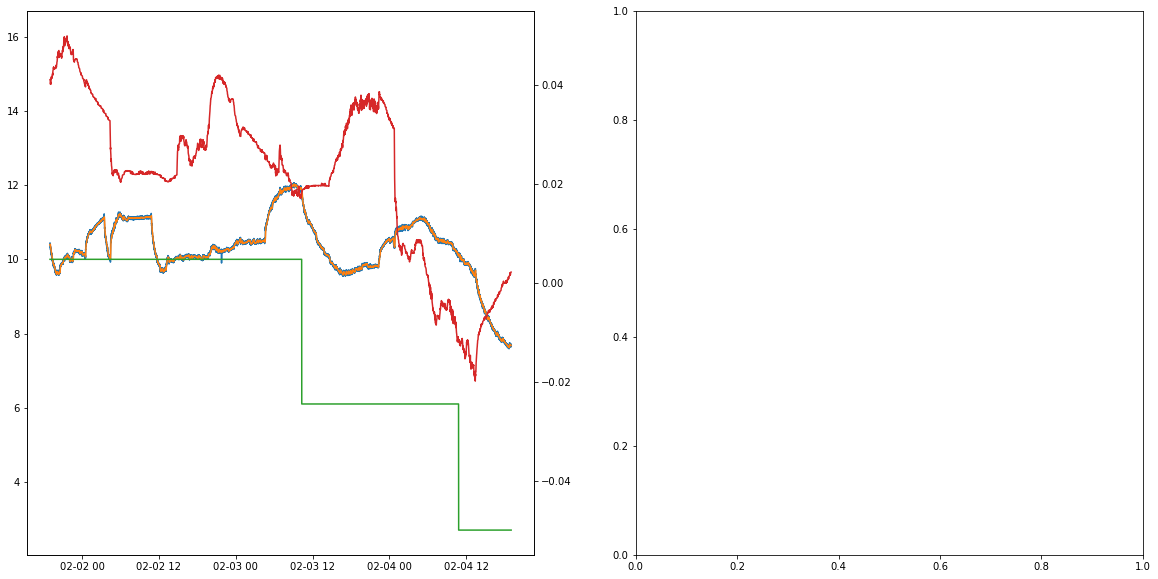

In [5]:
new_temperature_plot(year=2021, month=2, day=1, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=5, day=15, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=6, day=15, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=7, day=15, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=8, day=15, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=9, day=15, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=10, day=15, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=11, day=15, offset=3)

In [ ]:
new_temperature_plot(year=2021, month=12, day=15, offset=3)

In [ ]:
print(etc_telemetry_data.columns.values)
print(etc_telemetry_data)

In [ ]:
display(Image(filename='../correlation/temp_corr_before_sync.png'))

## Unsuccessful sorting and array modification

In [ ]:
print(min(telescope_data['time_recorded'][start_index+count]))

In [ ]:
print(telescope_data['time_recorded'].to_pydatetime()) # tried converting array of pandas Timestamp to datetime objects

In [35]:
print(telescope_data['time_recorded'][0].to_pydatetime()) # tried converting array of pandas Timestamp to datetime objects

2022-06-10 16:37:05.419966+00:00


In [ ]:
print(telescope_data['time_recorded'].apply(lambda x: x.to_pydatetime())) # tried converting array of pandas Timestamp to datetime objects

In [ ]:
telescope_data['time_recorded'] = telescope_data.assign(time_recored=lambda x: x['time_recorded'].to_pydatetime()) # save time conversion array and display
print(type(telescope_data['time_recorded'][0]))

In [17]:
print(type(sorted_tower_data.sort_values()[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [15]:
print(type(telescope_data['time_recorded'].apply(lambda x: x.to_pydatetime())[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
assert(tower_data['time_recorded']==tower_data.sort_values(['time_recorded'])['time_recorded'])
assert(tower_data['time_recorded']==tower_data.sort_values(['time_recorded'])['time_recorded'])

Here, we see strong correlation amongst all the columns related to the dome. However, the mirror-related quantities are not strongly correlated. We would expect the mirror temperature to rise along with the temperature inside the dome. 

In [ ]:
print('initial number of samples per table')
print(f'environmentmonitor_tower: {len(tower_data.index)}')
print(f'environmentmonitor_dome: {len(dome_data.index)}')
print(f'environmentmonitor_telescope: {len(telescope_data.index)}')
print(f'etc_seeing: {len(etc_seeing_data.index)}')
print(f'etc_telemetry: {len(etc_telemetry_data.index)}')
print(f'tcs_info: {len(tcs_info_data.index)}')

In [ ]:
# fig, ax = plt.subplots(ncols=4, figsize=(40,10))

# ax[0].scatter(tower_data['time_recorded'], tower_data['temperature'])
# ax[0].set_xlabel('time_recorded')
# ax[0].set_ylabel('temperature')

# ax[1].scatter(telescope_data['time_recorded'], telescope_data['mirror_avg_temp'])
# ax[1].set_xlabel('time_recorded')
# ax[1].set_ylabel('mirror_avg_temp')

# ax[2].scatter(telescope_data['time_recorded'], telescope_data['mirror_desired_temp'])
# ax[2].set_xlabel('time_recorded')
# ax[2].set_ylabel('mirror_desired_temp')

# ax[3].scatter(etc_telemetry['time_recorded'], etc_telemetry['seeing'])
# ax[3].set_xlabel('time_recorded')
# ax[3].set_ylabel('seeing')

# plt.savefig('seeing_vs_time.png')
# plt.show()